## RMSD using JAX 

## setup

In [49]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from codes.dMap_JAX import rmsd_jax as rjax
from codes.dMap_JAX import dMap_jax as djax

import jax.numpy as jnp

#### plot settings

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2
    %reload_ext autoreload
    
font = {'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#### load integrin trajectories

In [3]:
universe_cg_traj_reps = []


for rep in [2]:

    file_cg_traj_break_legs_rep = 'integrin-data/grains_cg/inputs_lammps/break_legs/rep_'+str(rep)+ '/dump22'

    
    file_cg_break_legs_top_rep = 'integrin-data/grains_cg/inputs_lammps/break_legs/rep_'+str(rep)+ '/data.nvt'


    topology_cg_break_legs_top_rep = mda.topology.LAMMPSParser.DATAParser(file_cg_break_legs_top_rep).parse()


    universe_cg_traj_reps.append( mda.Universe(topology_cg_break_legs_top_rep, file_cg_traj_break_legs_rep + '.dcd', 
                                               topology_format="LAMMPS", format="LAMMPS") )
    

#### catenate all trajectories

In [4]:
#### merge trajs
lag_n = 800
# use this for catentating multiple trajectories
#cat_trajs = np.concatenate(( np.array(universe_cg_traj_reps[0].trajectory[1::lag_n]), 
#                             np.array(universe_cg_traj_reps[1].trajectory[1::lag_n]),
#                             np.array(universe_cg_traj_reps[2].trajectory[1::lag_n]),
#                             np.array(universe_cg_traj_reps[3].trajectory[1::lag_n]),
#                             np.array(universe_cg_traj_reps[4].trajectory[1::lag_n]),
#                             np.array(universe_cg_traj_reps[5].trajectory[1::lag_n]) ))

test_trajs = np.array(universe_cg_traj_reps[0].trajectory[1::lag_n])


In [5]:
print(test_trajs.shape)

(500, 300, 3)


#### rmsd calculations using JAX

#### run RMSD

In [6]:
start = time.time()

#test_trajs == an array of shape nframes x n particles x 3.
#batch_ref_frame_size == number of reference frames to run at the same time.
rjax.run_rmsd(test_trajs, batch_ref_frame_size=100, output_file_prefix="test_folder/test_rmsd_")
print("RMSD calculations finished in {} seconds".format(time.time()-start))

RMSD calculations finished in 2.7836217880249023 seconds


#### load RMSD, check properties if needed

In [8]:
prmsd_jax = []
for i in range(100, test_trajs.shape[0]+1, 100):
    
    with open(r"test_folder/test_rmsd_"+str(i)+".pkl", "rb") as f:
        data = pickle.load(f)
        prmsd_jax.append(data['rmsd'])
        
prmsd_jax = np.concatenate(prmsd_jax)
print(prmsd_jax.shape)
prmsd_jax_nm = prmsd_jax/10 # Angstroms to nm


### check matrix properties
print(djax.check_is_symmetric(prmsd_jax_nm, tol=1e-6))
print(djax.check_is_symmetric(prmsd_jax_nm, tol=1e-5))

### enforce symmetry -- ideally, we can skip one of the upper/lower triangle calculations

n_matrix = prmsd_jax_nm.shape[0]

sym_prmsd_jax_nm = np.zeros((n_matrix, n_matrix))
upper_diag_prmsd_jax_nm = np.triu_indices_from(sym_prmsd_jax_nm, k=1)
prmsd_jax_nm[upper_diag_prmsd_jax_nm].shape

sym_prmsd_jax_nm[upper_diag_prmsd_jax_nm] = prmsd_jax_nm[upper_diag_prmsd_jax_nm]
sym_prmsd_jax_nm.T[upper_diag_prmsd_jax_nm] = prmsd_jax_nm[upper_diag_prmsd_jax_nm]

print(djax.check_is_symmetric(sym_prmsd_jax_nm, tol=1e-6))
print(djax.check_is_symmetric(sym_prmsd_jax_nm, tol=1e-5))

sym_prmsd_jax_nm = jnp.array(sym_prmsd_jax_nm)



(500, 500)
False
True
True
True


#### test calculations using MDAnalysis

799

In [44]:
def run_mda_rmsd(mda_universe_traj):
    
    '''Run RMSD using MDA
    '''
        
    test_lag_n = 800
    n_frames = mda_universe_traj.trajectory.n_frames/test_lag_n
    n_frames = int(n_frames)
    test_mda_prmsd = np.zeros((n_frames, n_frames)) 
    ref_index = 1
    for i in range(n_frames):
        r = rms.RMSD(mda_universe_traj, mda_universe_traj, ref_frame=ref_index).run(start=1,stop=mda_universe_traj.trajectory.n_frames,step=test_lag_n)
        ref_index += test_lag_n
    
        test_mda_prmsd[i] = r.results.rmsd[:, -1]  # select 3rd column with RMSD values
        
    
    return test_mda_prmsd

## executed in serial; alternatively can use parallelize in python
start = time.time()     
mda_prmsd = run_mda_rmsd(universe_cg_traj_reps[0])
print("MDA RMSD calculations finished in {} seconds".format(time.time()-start)) 

MDA RMSD calculations finished in 25.929171800613403 seconds


In [45]:

mda_prmsd_nm = mda_prmsd/10

### check matrix properties
print(djax.check_is_symmetric(mda_prmsd_nm, tol=1e-6))
print(djax.check_is_symmetric(mda_prmsd_nm, tol=1e-4))

True
True


In [68]:
print((mda_prmsd_nm - sym_prmsd_jax_nm).min())
print((mda_prmsd_nm - sym_prmsd_jax_nm).max())
print(np.abs(mda_prmsd_nm - sym_prmsd_jax_nm).max())

-2.1457672e-06
2.861023e-06
2.861023e-06


#### plot RMSDs

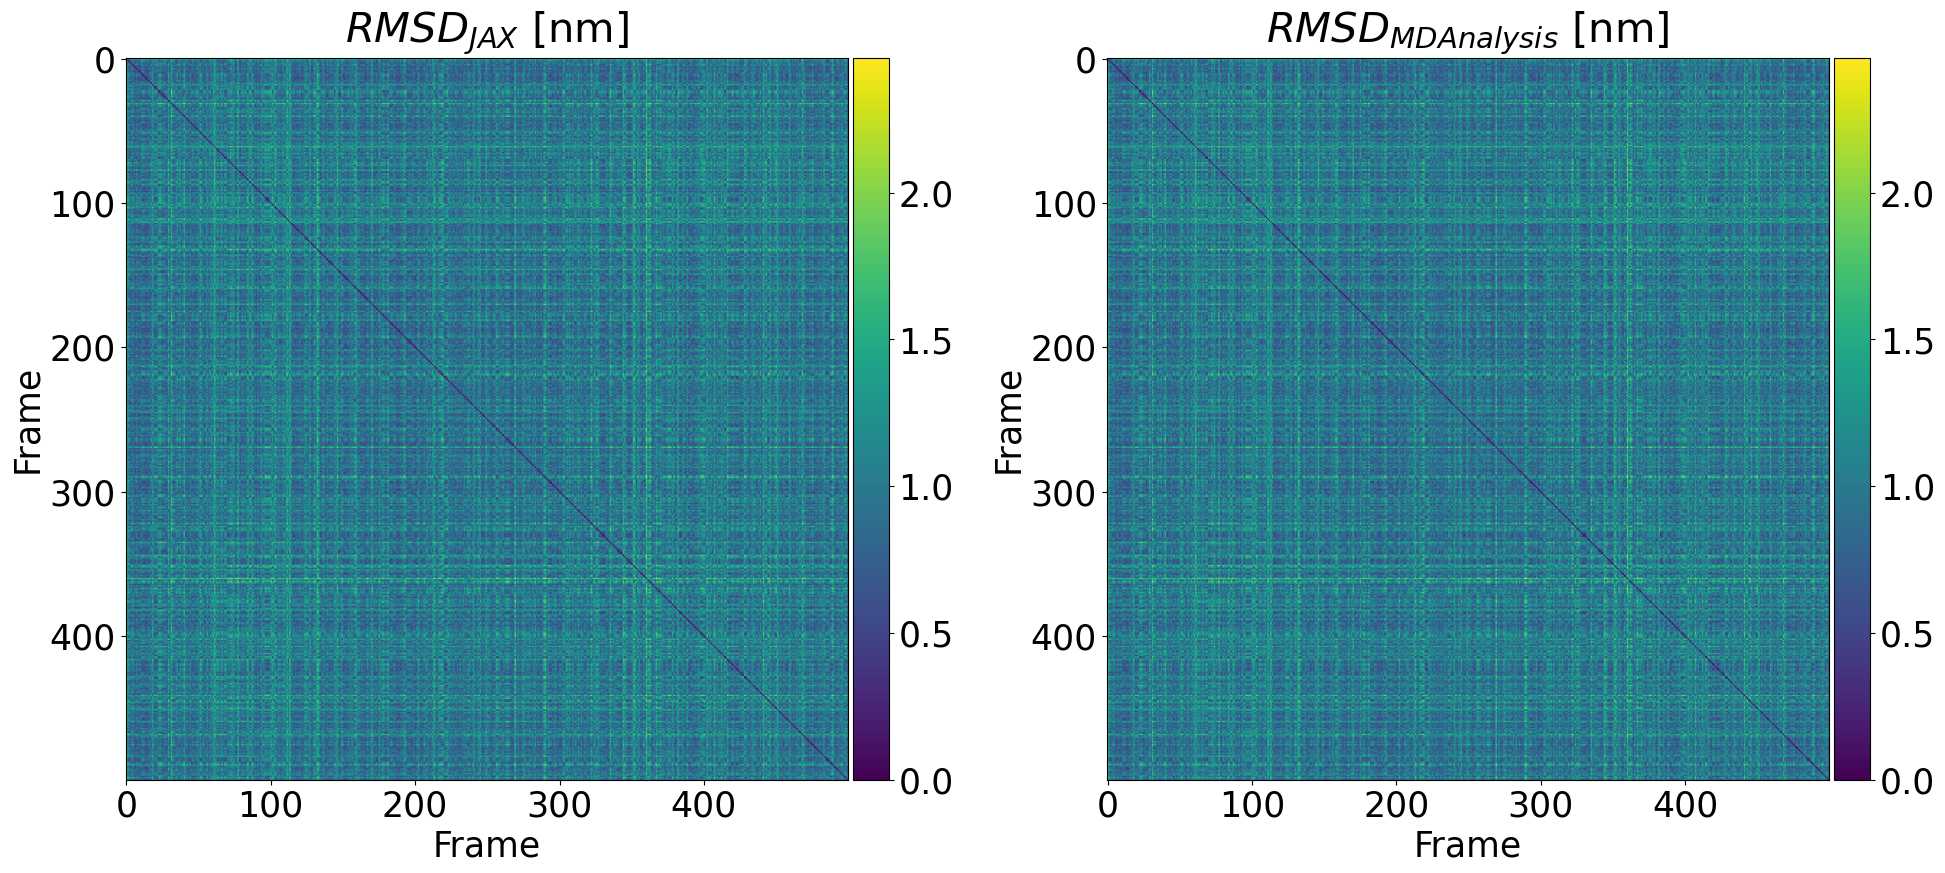

In [65]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axes = plt.subplots(1,2, figsize = (20,20))
axes = axes.flatten()
im1 = axes[0].imshow(sym_prmsd_jax_nm, cmap='viridis')
axes[0].set_xlabel('Frame')
axes[0].set_ylabel('Frame')
axes[0].set_title('$RMSD_{JAX}$ [nm]')


im2 = axes[1].imshow(mda_prmsd_nm, cmap='viridis')
axes[1].set_xlabel('Frame')
axes[1].set_ylabel('Frame')
axes[1].set_title('$RMSD_{MDAnalysis}$ [nm]')


divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


fig.tight_layout()    
#fig.savefig('jax-mda-rmsd-heat-map-comparison.png',dpi=150)